# Годовой проект - Определение популярности геолокации для размещения банкомата

`Куратор`: 
- Ковалева Александра  
    
`Команда`:
- Цуканов Николай Сергеевич
- Исхаков Ильдус Халитович
- Устименко Кирилл Александрович
- Волокитина Анастасия Евгеньевна

## Исходные данные

`id` - идентификатор банкомата  
`atm_group` - принадлежность банкомата к группе  
`address` - адрес банкомата на английском  
`address_rus` - адрес банкомата на русском  
`lat` - широта  
`long` - долгота    
`target` - целевая метрика  

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

Загрузим данные:

In [3]:
df_train = pd.read_csv('train.csv', index_col=0)
df_test = pd.read_csv('test.csv', index_col=0)

In [4]:
train_rows, train_columns = df_train.shape
test_rows, test_columns = df_test.shape
print(f'Данные для обучающей выборки состоят из {train_rows} строки и {train_columns} столбцов.') 
print(f'Данные для тестовой выборки состоят из {test_rows} строк и {test_columns} столбцов.') 

Данные для обучающей выборки состоят из 6261 строки и 7 столбцов.
Данные для тестовой выборки состоят из 2504 строк и 6 столбцов.


Посмотрим на наши наблюдения:

In [6]:
df_train.sample(5)

,id,atm_group,address,address_rus,lat,long,target
4267,2703.0,3185.5,"UL.RUSSKAJA, 1 NOVOSIBIRSK","Русская улица, 1, микрорайон Шлюз, Советский р...",54.849385,83.041630,-0.114509
1744,2658.0,3185.5,UL. CSHORSA-8 V BELGOROD,NaN,NaN,NaN,-0.048848
2562,4690.0,496.5,LENINA 17 BOLOTNOE,"улица Ленина, 17, город Болотное, Новосибирска...",55.670955,84.387594,-0.111910
3016,4733.0,5478.0,"D. 13, UL. GERMANA TITOVA BARNAUL G","улица Германа Титова, 13, Барнаул, Алтайский к...",53.382361,83.725823,-0.050917
2863,1553.0,1942.0,51-1 BIRYULEVSKAYA STR. MOSCOW,"Бирюлёвская улица, 51к1, Москва, Россия, 115372",55.582655,37.671507,0.067989


## Часть 1 | EDA и визуализация

Посмотрим на типы данных:

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6261 entries, 0 to 6260
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           6261 non-null   float64
 1   atm_group    6261 non-null   float64
 2   address      6261 non-null   object 
 3   address_rus  5957 non-null   object 
 4   lat          5957 non-null   float64
 5   long         5957 non-null   float64
 6   target       6261 non-null   float64
dtypes: float64(5), object(2)
memory usage: 391.3+ KB


Посмотрим на наличие пропусков:

In [11]:
df_train.isna().sum()

id               0
atm_group        0
address          0
address_rus    304
lat            304
long           304
target           0
dtype: int64

In [12]:
data_gaps = round(100 * (df_train.shape[0] - df_train[df_train['address_rus'].notna()].shape[0]) / df_train.shape[0], 2)

In [13]:
print(f'Имеется 304 банкомата ({data_gaps}% от общего числа) без указания адреса на русском и географических координат.')

Имеется 304 банкомата (4.86% от общего числа) без указания адреса на русском и географических координат.


Посмотрим на наличие полных дублей:

In [15]:
df_train.duplicated().sum()

0

Дубли отсутствуют.

Посмотрим на количественные переменные:

In [18]:
pd.options.display.float_format = '{:,.2f}'.format

In [19]:
df_train.describe(include='number')

,id,atm_group,lat,long,target
count,"6,261.00","6,261.00","5,957.00","5,957.00","6,261.00"
mean,"4,419.12","4,417.94",54.16,63.52,0.00
std,"2,547.21","2,430.41",4.35,33.02,0.09
min,5.00,32.00,42.06,19.94,-0.15
25%,"2,228.00","1,942.00",52.25,37.86,-0.06
50%,"4,392.00","5,478.00",55.07,48.58,-0.02
75%,"6,660.00","5,478.00",56.12,84.95,0.04
max,"8,811.00","8,083.00",69.49,173.71,0.22


In [20]:
df_test.describe(include='number')

,id,atm_group,lat,long
count,"2,504.00","2,504.00","2,388.00","2,388.00"
mean,"4,368.24","4,379.68",54.08,63.45
std,"2,530.93","2,421.99",4.29,32.21
min,1.00,32.00,42.65,20.44
25%,"2,146.50","1,942.00",52.21,37.81
50%,"4,437.50","5,478.00",55.04,49.15
75%,"6,468.50","5,478.00",56.10,84.95
max,"8,808.00","8,083.00",69.50,160.85


Широта может иметь значения от 0 до 90 градусов, долгота - от 0 до 180 градусов. Наши наблюдения не выходят за рамки этих пределов.  

Посмотрим на категориальные переменные:

In [23]:
df_train.describe(include='object')

,address,address_rus
count,6261,5957
unique,5343,4553
top,"HOROSHEVSKOE SH,V38 MOSKVA","улица Ватутина, 107, Новосибирск, Россия, 630024"
freq,7,8


In [24]:
df_test.describe(include='object')

,address,address_rus
count,2504,2388
unique,2138,1952
top,30/32 KUTUZOVSKIY PR. MOSCOW,"Кутузовский проспект, 30, Москва, Россия, 121165"
freq,6,6


Посмотрим сколько банкоматов принадледит той или иной группе:

In [27]:
df_train.groupby('atm_group', as_index=False).agg(Банкоматов=('atm_group', 'count')).sort_values(by='Банкоматов', ascending=False)

,atm_group,Банкоматов
5,"5,478.00",2662
3,"1,942.00",1160
6,"8,083.00",1050
1,496.50,616
4,"3,185.50",594
2,"1,022.00",136
0,32.00,43


Уберем возможные пробелы для наших записей:

In [36]:
df_train['address_rus'] = df_train['address_rus'].apply(lambda x: x.strip() if pd.notnull(x) else None)

Посмотрим на длину записей адресов:

In [44]:
df_train['len_address'] = df_train['address_rus'].apply(lambda x: len(x) if x != None else None)

In [46]:
df_train['len_address'].min(), df_train['len_address'].max()

(27.0, 144.0)

Посмотрим на самый длинный адрес в наших данных:

In [49]:
df_train[df_train['len_address'] == 144]['address_rus'].loc[3579]

'Волжская улица, 1, посёлок городского типа Ванино, городское поселение Рабочий Посёлок Ванино, Ванинский район, Хабаровский край, Россия, 682860'

Каких-то аномально длинных адресов нет.

Посмотрим на формат записей адресов банкоматов на русском:

In [55]:
df_train['address_rus'][0]

'улица А.О. Емельянова, 34, Южно-Сахалинск, Сахалинская область, Россия'

In [57]:
df_train['address_rus'][10]

'Большая Московская улица, 90А, Владимир, Россия, 600000'

In [59]:
df_train['address_rus'][1343]

'Магаданская улица, 31, посёлок Хандыга, Томпонский муниципальный район, Республика Саха (Якутия), Россия, 678720'

Спарсим наши адреса на русском на составляющие: `почтовый индекс`, `страна`, `город`, `улица`, `дом`:

__1. Достанем из адреса почтовый индекс, если он имеется:__

In [63]:
def get_postal_code(address: str):
    address = address.split(', ')
    if address[-1].isdigit():
        return address[-1]
    else:
        return None

In [65]:
df_train['postal_code'] = df_train['address_rus'].apply(lambda x: get_postal_code(x) if pd.notnull(x) else None)

В России принята 6-значная система почтовых индексов XXXYYY, где XXX - код субъекта федерации, YYY - номер почтового отделения в нем, но крупные города, такие как, например, Москва имеет несколько кодов. Проверим какой длины имеющиеся индексы в наших данных:

In [68]:
df_train['len_postal_code'] = df_train['postal_code'].apply(lambda x: len(x) if pd.notnull(x) else None)

In [70]:
df_train['len_postal_code'].unique()

array([nan,  6.])

Все почтовые индексы имеют нужную длину.

__2. Достанем из адреса страну, если она имеется:__

In [74]:
def get_country(address: str):
    address = address.split(', ')
    if address[-1].isalpha():
        return address[-1]
    elif address[-2].isalpha():
        return address[-2]
    else:
        return None

In [76]:
df_train['country'] = df_train['address_rus'].apply(lambda x: get_country(x) if pd.notnull(x) else None)

In [78]:
df_train['country'].unique()

array(['Россия', None], dtype=object)

Без неожиданностей - все адреса банкоматов в России.

__3. Достанем из адреса город, если он имеется:__

Возьмем список городов России из Википедии:

In [83]:
url = 'https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8'
test = pd.read_html(url)[0]
cities = test['Город']

In [84]:
cities

0           Абаза
1          Абакан
2        Абдулино
3          Абинск
4         Агидель
          ...    
1120    Ярославль
1121       Ярцево
1122    Ясногорск
1123        Ясный
1124       Яхрома
Name: Город, Length: 1125, dtype: object

In [85]:
def get_city(address: str):
    for city in cities:
        if city in address:
            return city
        else:
            None

In [86]:
df_train['city'] = df_train['address_rus'].apply(lambda x: get_city(x) if pd.notnull(x) else None)

Посмотрим какая доля записей осталась без города среди адресов, которые имеют запись на русском:

In [88]:
no_city = round(100 * df_train[(df_train['address_rus'].notna()) & (df_train['city'].isnull())].shape[0] / df_train[df_train['address_rus'].notna()].shape[0], 1)

In [89]:
print(f'{no_city}%')

1.4%


__4. Достанем из адеса улицу, если она имеется:__

Регулярное выражение, чтобы достать из адреса название улицы, когда сперва идет слово `улица`, а потом название:

In [92]:
second_street_pattern = r"(улица)([А-Яа-яё0-9-\s+\.]+)"

Регулярное выражение, чтобы достать из адреса название улицы, когда сперва идет название, а потом слово `улица`:

In [94]:
first_street_pattern = r"([А-Яа-яё0-9-\s+\.]+)(улица)"

Регулярное выражение, чтобы достать название улицы, когда сперва идут слова `проспект`, `проезд`, `переулок`, `набережная`, `площадь`, `бульвар`, `шоссе`, `тракт`, `квартал`, `микрорайон`, а потом название:

In [99]:
second_group_street_patterns = [r"(проспект)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(проезд)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(переулок)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(набережная)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(площадь)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(бульвар)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(шоссе)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(тракт)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(квартал)([А-Яа-яё0-9-\s+\.]+)", \
                                r"(микрорайон)([А-Яа-яё0-9-\s+\.]+)"]

Регулярное выражение, чтобы достать название улицы, когда сперва идет название, а потом слова `проспект`, `проезд`, `переулок`, `набережная`, `площадь`, `бульвар`, `шоссе`, `тракт`, `квартал`, `микрорайон`:

In [101]:
first_group_street_patterns = [r"([А-Яа-яё0-9-\s+\.]+)(проспект)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(проезд)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(переулок)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(набережная)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(площадь)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(бульвар)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(шоссе)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(тракт)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(квартал)", \
                               r"([А-Яа-яё0-9-\s+\.]+)(микрорайон)"]

Регулярное выражение, чтобы достать `номер дома`:

In [103]:
number_pattern = r"([\d][0-9а-жёА-Ж\.\/]+|(\d+))"

In [105]:
def get_part_street_name(address: str):
    try:
        name_street = re.search(second_street_pattern, address).group(2)
        return name_street.strip()
    except:
        name_street = None
    
    try:
        name_street = re.search(first_street_pattern, address).group(1)
        return name_street.strip()
    except:
        name_street = None
        
    for pattern in second_group_street_patterns:
         try:
            name_street = re.findall(pattern, address)
            return (name_street[0][0] + name_street[0][1]).strip()
         except:
            name_street = None
            
    for pattern in first_group_street_patterns:
         try:
            name_street = re.findall(pattern, address)
            return (name_street[0][0] + name_street[0][1]).strip()
         except:
            name_street = None
    return name_street

In [108]:
df_train['street_name'] = df_train['address_rus'].apply(lambda x: get_part_street_name(x))

Посмотрим адреса, которые есть на русском и к которым мы не смогли достать название улицы:

In [114]:
empty_street = df_train[(df_train['address_rus'].notna()) & (df_train['street_name'].isnull())]
empty_street['address_rus'].head(20)

8      деревня Веледниково, городской округ Истра, Мо...
30               19-я линия, 10, Иваново, Россия, 153031
145    метро Площадь Габдуллы Тукая, Центральная лини...
189    автодорога Красноярск-Железногорск, 20 км, Бер...
249    срезка на 5 км, территория Спортивный клуб Ром...
299    Буденновский лес, Красногвардейский район, Бел...
300    Буденновский лес, Красногвардейский район, Бел...
317    посёлок Красный Бор, 1, Ярославский район, Яро...
400    посёлок Ростовка, 23, Омский район, Омская обл...
438    СНТ 60 лет Октября, 60, Старый Оскол, Белгород...
456    садовое товарищество Грибники, Венёвский район...
497    А-181 Скандинавия, 132-й километр, Выборгский ...
510    деревня Колпино, Краснохолмский район, Тверска...
582    КАД, 29-й километр, внешнее кольцо, Санкт-Пете...
590    СНТ Выбор, 194, село Немчиновка, Одинцовский р...
594    посёлок Молодёжный, 14, городской округ Подоль...
596    КАД, 29-й километр, внешнее кольцо, Санкт-Пете...
665    поселок Новые Лапсары, г

In [117]:
empty_street.isna().sum()

id                   0
atm_group            0
address              0
address_rus          0
lat                  0
long                 0
target               0
len_address          0
postal_code        154
len_postal_code    154
country              0
city                20
street_name        157
dtype: int64

In [118]:
steet_gaps = round(100 * empty_street['street_name'].isna().sum() / df_train[df_train['address_rus'].notna()].shape[0],1)
print(f'Таких адресов получилось {steet_gaps}%.')

Таких адресов получилось 2.6%.


__5. Достанем номера домов для адресов, из которых удалось достать название улицы:__

In [124]:
def get_number(address: str):
    try:
        number = re.search(number_pattern, address).group(0)
        return number.strip()
    except:
        number = None
    return number

In [125]:
df_train['number'] = df_train[df_train['address_rus'].notna()]['address_rus'].apply(lambda x: get_number(x.split(', ')[1]))

In [128]:
df_train.sample(5)

,id,atm_group,address,address_rus,lat,long,target,len_address,postal_code,len_postal_code,country,city,street_name,number
1937,"5,969.00","5,478.00","D. 1, UL. PARIZHSKOI KOMM SLYUDYANKA G","улица Парижской Коммуны, 1, Слюдянка, Иркутска...",51.66,103.72,-0.05,63.00,None,NaN,Россия,Иркутск,Парижской Коммуны,1
3404,"7,455.00","5,478.00","D. 20, UL. KIROVA OMSK G","улица Кирова, 20, Омск, Россия, 644041",54.94,73.42,0.00,38.00,644041,6.00,Россия,Киров,Кирова,20
4249,"2,580.00","3,185.50","GAGARINA, 14A TROICK","улица Гагарина, 14А, Троицк, Челябинская облас...",54.08,61.53,-0.07,56.00,None,NaN,Россия,Гагарин,Гагарина,14А
1562,984.00,"1,942.00",35 KHOROSHEVSKOE H. MOSCOW,"Хорошёвское шоссе, 35Ас1, Москва, Россия, 123007",55.78,37.52,0.02,48.00,123007,6.00,Россия,Москва,Хорошёвское шоссе,35А
5679,"5,743.00","5,478.00","D. 60A, UL. RYABIKOVA ULYANOVSK G","улица Рябикова, 60А, Ульяновск, Россия, 432045",54.28,48.29,-0.08,46.00,432045,6.00,Россия,Ульяновск,Рябикова,60А


Посмотрим какое количество городов представлено в наших данных:

In [131]:
df_train['city'].nunique()

422

Выведем топ-10 городов по численности банкоматов по городам:

In [134]:
top_10_atms = df_train.groupby('city', as_index=False).agg(atm=('id', 'count')).sort_values(by='atm', ascending=False).head(10)

In [136]:
top_10_atms['share,%'] = round(100 * top_10_atms['atm'] / df_train.shape[0], 1)

In [138]:
top_10_atms

,city,atm,"share,%"
262,Москва,504,8.00
207,Красноярск,214,3.40
343,Санкт-Петербург,176,2.80
287,Новосибирск,138,2.20
184,Киров,126,2.00
203,Краснодар,121,1.90
296,Омск,114,1.80
78,Владивосток,99,1.60
130,Екатеринбург,94,1.50
10,Амурск,91,1.50


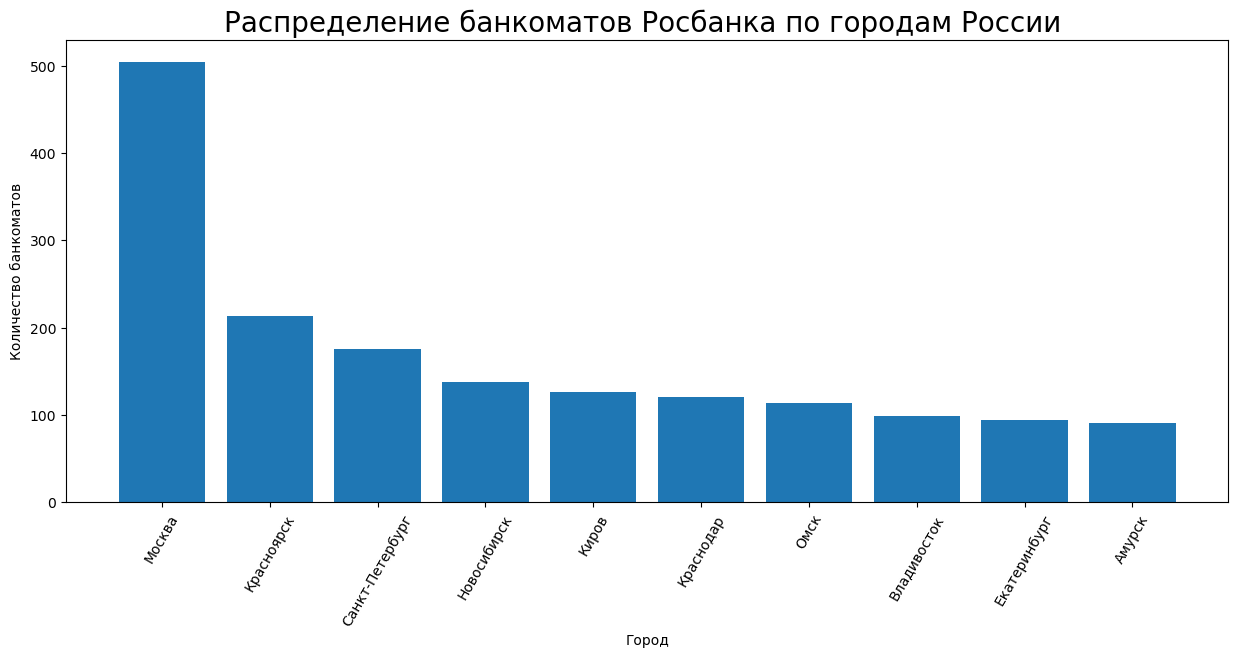

In [140]:
plt.figure(figsize=(15, 6))
plt.bar(x=top_10_atms['city'], height=top_10_atms['atm'])
plt.title('Распределение банкоматов Росбанка по городам России ', fontsize=20)
sns.color_palette('pastel')
plt.xticks(rotation=60)
plt.xlabel('Город')
plt.ylabel('Количество банкоматов')

plt.show()

Посмотрим на распределение таргета:

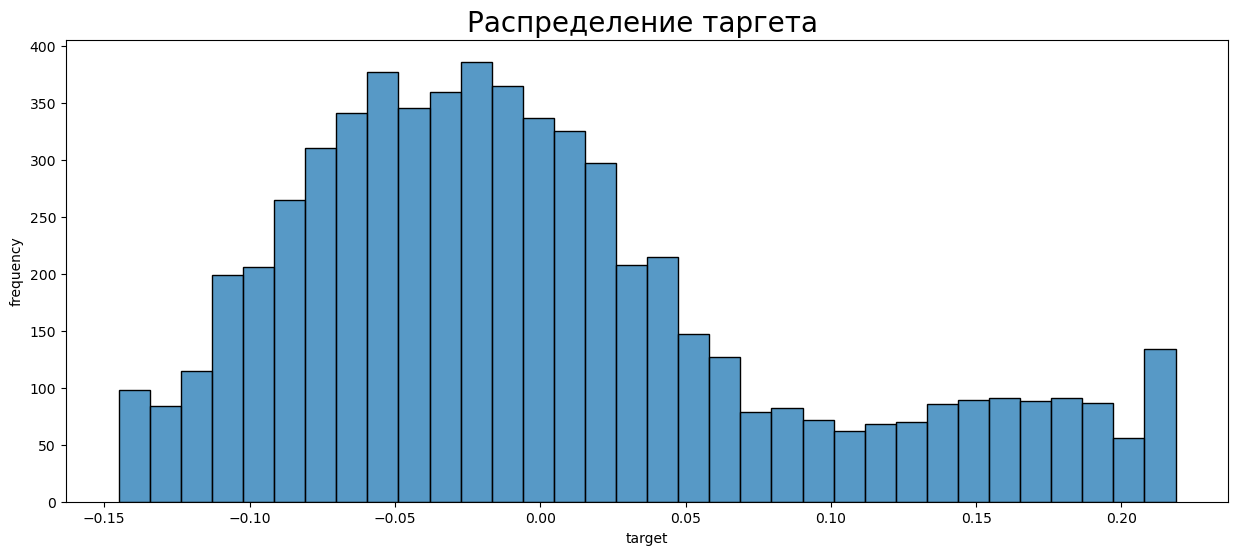

In [142]:
plt.figure(figsize=(15, 6))
plt.title('Распределение таргета ', fontsize=20)
sns.histplot(df_train, x='target')
sns.color_palette('pastel')
plt.xlabel('target')
plt.ylabel('frequency')

plt.show()

In [144]:
print(f'Имеем распределение со средним {df_train.target.mean():.3f} и стандартным отклонением {df_train.target.std():.2f}')

Имеем распределение со средним 0.001 и стандартным отклонением 0.09


In [465]:
df_train['address_rus'][1343]

'Магаданская улица, 31, посёлок Хандыга, Томпонский муниципальный район, Республика Саха (Якутия), Россия, 678720'

Сделаем промежуточный вывод о структуре данных и потенциальных проблемах. По записи 1343 (см. ячейку выше) можно видеть муниципальный формат записи адреса. В муниципальном делении указывают структуры местного самоуправления, например, регион, районы, сельские и городские поселения, муниципальные округа. Данный факт усложняет формат записи адреса для его парсинга на составлящие. Также имеются записи о банкоматах в нашем датасете, адресов на русском с географическими координатами которых нет вовсе.

Построим корреляционную матрицу с количеством банкоматов и городом:

Для этого сперва закодируем каждый город с помощью Target encoding, т.e. каждую категорию, в нашем случае это город, закодируем средним значением целевой переменной по этой категории.

In [231]:
df_train['city'].nunique()

422

In [280]:
df_train['feature_mean'] = df_train.groupby('city')['target'].transform('mean')

Если кодировать при помощи счетчиков сразу все обучающие данные, то мы переобучимся. Применим сглаживание:

$$
p = \frac{\text{mean(target)} \cdot n_{\text{rows}} + \alpha \cdot \text{GlobalTarget}}{n_{\text{rows}} + \alpha}
$$

In [517]:
def counter_with_smoothing(df, city, target, alpha):
    """
    p - число, которым кодируем категорию
    n_rows - число строк в категории
    mean(target) - среднее значение целевой переменной по категории
    Global_target - среднее значение целевой переменной по всей обучающей выборке
    α - гиперпараметр
    """
    df['feature_mean'] = df.groupby(city)[target].transform('mean')

    global_mean = df[target].mean()

    df['city_count'] = df.groupby(city)[target].transform('count')

    df['p'] = (df['feature_mean'] * df['city_count'] + alpha * global_mean) / (df['city_count'] + alpha)

    return df

In [539]:
df_train = counter_with_smoothing(df_train, 'city', 'target', 30)

In [541]:
df_train

,id,atm_group,address,address_rus,lat,long,target,len_address,postal_code,len_postal_code,country,city,street_name,number,count,feature_mean,city_count,p
0,"8,526.00",32.00,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.94,142.74,0.01,70.00,None,NaN,Россия,Южно-Сахалинск,А.О. Емельянова,34,1,0.04,28.00,0.02
1,"8,532.00",32.00,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.94,142.75,0.03,69.00,None,NaN,Россия,Комсомольск,Комсомольская,259,1,0.04,66.00,0.03
2,"8,533.00",32.00,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.96,142.74,0.01,70.00,None,NaN,Россия,Южно-Сахалинск,Коммунистический проспект,None,1,0.04,28.00,0.02
3,"8,684.00",32.00,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.81,37.52,-0.09,51.00,125315,6.00,Россия,Москва,Ленинградский проспект,76А,1,0.04,504.00,0.03
4,37.00,32.00,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.34,88.21,0.08,67.00,663302,6.00,Россия,Гвардейск,Гвардейская площадь,2,1,0.01,5.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6256,"4,402.00","8,083.00","FEDORA POPOVA, 14 Yakutsk","улица Федора Попова, 14, Якутск, Республика Са...",62.05,129.75,0.21,73.00,677009,6.00,Россия,Якутск,Федора Попова,14,1,0.04,65.00,0.02
6257,"4,421.00","8,083.00","STROITELEY, 43 Novokuznetsk","проспект Строителей, 43, Новокузнецк, Кемеровс...",53.77,87.12,0.06,73.00,654005,6.00,Россия,Новокузнецк,проспект Строителей,43,1,-0.03,32.00,-0.01
6258,"4,422.00","8,083.00","Rublevskoye sh, 62 Moskva","Рублёвское шоссе, 62, Москва, Россия, 121609",55.77,37.38,0.11,44.00,121609,6.00,Россия,Москва,Рублёвское шоссе,62,1,0.04,504.00,0.03
6259,"4,426.00","8,083.00","EFANOVA, 22 Zyryanskoye","улица Ефанова, 22, село Зырянское, Зырянский р...",56.84,86.64,0.15,75.00,None,NaN,Россия,Томск,Ефанова,22,1,0.04,85.00,0.03


<Axes: >

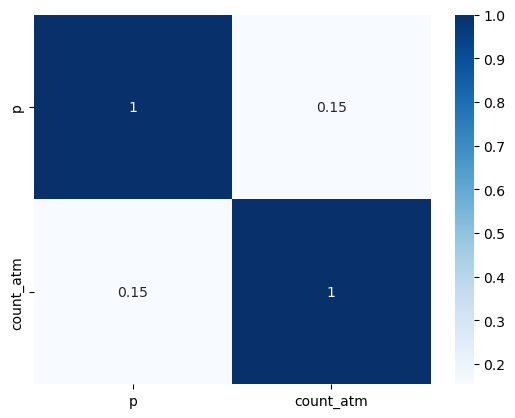

In [543]:
df_corr = df_train.groupby('city', as_index=False).agg(count_atm=('lat', 'count'), \
                                                               p=('p', 'mean'))

sns.heatmap(df_corr[['p', 'count_atm']].corr(), cmap="Blues", annot=True)

Попробую проинтепретировать полученное значение: в целом у нас наблюдается положительная корреляция между закодированным числом города и числом банкоматов в нем, но зависимость слабая. Хоть и есть некоторая связь, но она вряд ли объясняет поведение числа банкоматов (count_atm).

__Применим библиотеку Folium для визуализации геоданных наших банкоматов:__

In [154]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [156]:
import folium
from folium.plugins import HeatMap

In [198]:
atm_coordinates = df_train[(df_train['lat'].notna()) & (df_train['long'].notna())][['lat', 'long']]

In [202]:
if 'count' not in atm_coordinates.columns:
    atm_coordinates['count'] = 1  # Если нет столбца с весами, назначим по 1 банкомату

# Создаем карту
m = folium.Map(location=[atm_coordinates['lat'].mean(), atm_coordinates['long'].mean()], zoom_start=6)

# Добавляем слой тепловой карты
heat_data = atm_coordinates[['lat', 'long', 'count']].values.tolist()
HeatMap(heat_data).add_to(m)

# Сохраняем карту в HTML
m.save("heatmap.html")
print("Тепловая карта сохранена в файл heatmap.html")

Тепловая карта сохранена в файл heatmap.html


## Часть 2 | Модель только на вещественных числах

(далее добавим категориальные)

In [785]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE, mean_absolute_percentage_error as MAPE, r2_score as R2

In [787]:
df_train_filtered.isna().sum()

id                    0
atm_group             0
address               0
address_rus           0
lat                   0
long                  0
target                0
len_address           0
postal_code        1259
len_postal_code    1259
country               0
city                 83
street_name         157
number              199
count                 0
feature_mean         83
city_count            0
p                     0
dtype: int64

In [789]:
df_train_filtered = df_train[(df_train['lat'].notna()) & (df_train['long'].notna())]
df_test_filtered = df_test[(df_test['lat'].notna()) & (df_test['long'].notna())]

In [791]:
df_train_filtered['p'].fillna(round(df_train_filtered['p'].median(), 2), inplace=True)

C:\Users\DNS\AppData\Local\Temp\ipykernel_23904\3576405579.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_filtered['p'].fillna(round(df_train_filtered['p'].median(), 2), inplace=True)
C:\Users\DNS\AppData\Local\Temp\ipykernel_23904\3576405579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_filtered['p'].fillna(round(

In [793]:
df_train_filtered['city_count'].fillna(round(df_train_filtered['city_count'].median(), 2), inplace=True)
df_test_filtered['city_count'].fillna(round(df_test_filtered['city_count'].median(), 2), inplace=True)

C:\Users\DNS\AppData\Local\Temp\ipykernel_23904\4294653977.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_filtered['city_count'].fillna(round(df_train_filtered['city_count'].median(), 2), inplace=True)
C:\Users\DNS\AppData\Local\Temp\ipykernel_23904\4294653977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_filtered[

In [795]:
df_test['city'] = df_test['address_rus'].apply(lambda x: get_city(x) if pd.notnull(x) else None)

In [796]:
df_test['city_count'] = df_test.groupby('city')['atm_group'].transform('count')

In [799]:
y_train = df_train_filtered['target']
X_train = df_train_filtered[['lat', 'long', 'city_count', 'p']]

In [801]:
X_test = df_test_filtered[['lat', 'long', 'city_count']]

In [803]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [805]:
y_train_predict = model_lr.predict(X_train)

Посчитаем метрики качества:

In [808]:
print(f'''Metrics:
mae_test={MAE(y_train, y_train_predict)}
mape_test={MAPE(y_train, y_train_predict)}
R2_test={R2(y_train, y_train_predict)}
''')

Metrics:
mae_test=0.06203874424467889
mape_test=2.700312472950015
R2_test=0.13400646764854418

